# Colourizing Black and White Images - Predictions

The main goal of this Machine learning document is to train the AI's and test out there accuracy, with the test and training set that was made in the Provisioning phase.  

AI's I am going to use :
- (Feed-forward) Neural Network
- (SVM) Suport Vector Machine 

created by: Mickey krekels
Class: AI45

## loading the imports

In [1]:
import PIL
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl
import matplotlib.image as mpimg
from skimage.io import imread, imshow ,imsave
from skimage.color import rgb2lab, lab2rgb ,gray2rgb,rgb2gray
from skimage.transform import resize
import pandas as pd
import numpy as np
import csv
import csv
import ast
import cv2

import sys
sys.path.insert(1, 'D:/AI_software/Jupyter/Saved Files/Neural Network/Sigmoid_NN') #imports neural network

import pickle 

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset  

In [2]:
df_trainset = pd.read_csv("data/Training_Set/Image_Training_set.csv")
df_TestSet  = pd.read_csv("data/Test_Set/Image_Testing_set.csv")

df_train_color = df_trainset['Path_Color']
df_train_grey  = df_trainset['Path_Grey']

df_test_color = df_TestSet['Path_Color']
df_test_grey  = df_TestSet['Path_Grey']

# (Feed-forward) Neural Network 

## Neural Network code 

The code for the Perceptron. To make things a bit easier I use sigmoid as an activation function.

In [3]:
# %load D:/AI_software/Jupyter/Saved Files/Neural Network/Sigmoid_NN/Perceptron.py
import numpy as np

class Perceptron:
    
    def __init__(self,inputs, activation = 's',bias=1.0):
        self.weights = (np.random.rand(inputs+1)*2)-1
        self.bias = bias 
        self.activation = activation
        
    def run(self,x):
        sum = np.dot(np.append(x,self.bias),self.weights)    
        
        if(self.activation == 't'):
            return self.tanh(sum)   
        
        if(self.activation == 'r'):
            return self.relu(sum)    
        
        return self.sigmoid(sum)
    
    def set_weights(self,w_init):
        self.weights = np.array(w_init)
        
    # Activation fuction
        
    def sigmoid(self,x):
        result = 1/(1 + np.exp(-x))
        return result
       
    def tanh(self,x):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return t
    
    def relu(self,x):
        r = max(0.0, x)
        return r
    

The code for the MultiLayerPerceptron.

In [4]:
# %load D:/AI_software/Jupyter/Saved Files/Neural Network/Sigmoid_NN/MultiLayerPerceptron.py
import numpy as np
import Perceptron as pr 

class MultiLayerPerceptron:
    
    def __init__(self,layers,activations=[],bias =1.0,eta = 0.5):
               
        self.layers = np.array(layers,dtype=object)
        self.bias = bias
        self.eta = eta
        self.network = [] # The list of lists of neurons
        self.values = []  # The list of lists of output values
        self.d = []       # The list of lists of error terms (lowercase deltas)

        for i in range(len(self.layers)):
            self.values.append([])
            self.d.append([])
            self.network.append([])
            self.values[i] = [0.0 for j in range(self.layers[i])]
            self.d[i] = [0.0 for j in range(self.layers[i])]
            if i > 0:      #network[0] is the input layer, so it has no neurons
                for j in range(self.layers[i]): 
                    self.network[i].append(Perceptron(inputs = self.layers[i-1]
                                                         ,activation = 's'
                                                         , bias = self.bias))
        
        self.network = np.array([np.array(x) for x in self.network],dtype=object)
        self.values = np.array([np.array(x) for x in self.values],dtype=object)
        self.d = np.array([np.array(x) for x in self.d],dtype=object)
        
    def set_weights(self,w_init):
        for x in range(len(w_init)):
            for y in range(len(w_init[x])):
                self.network[x+1][y].set_weights(w_init[x][y])
        
    def print_weights(self):  
        print()
        for x in range(1,len(self.network)):
            for y in range(self.layers[x]):
                print("Layer: ",x+1," Neuron: ",y,self.network[x][y].weights)
        print()
        
        
    def run(self,x):
        x = np.array(x, dtype=object)
        self.values[0] = x
        
        for x in range(1,len(self.network)):
            for y in range(self.layers[x]):
                self.values[x][y] = self.network[x][y].run(self.values[x-1])
        return self.values[-1]
    
    def Backpropagation(self, x, y):
        x = np.array(x,dtype=object)
        y = np.array(y,dtype=object)

        #Feed a sample to the network 
        output = self.run(x)
        
        #Calculate the MSE
        error = (y - output)
        MSE = sum(error ** 2) /self.layers[-1] # ** is squared

        # STEP 3: Calculate the output error terms
        self.d[-1] = output * (1- output) * (error)

        #Calculate the error term of each unit on each layer
        for i in reversed(range(1,len(self.network)-1)):
            for h in range(len(self.network[i])):
                fwd_error = 0.0
                for k in range(self.layers[i+1]): 
                    fwd_error += self.network[i+1][k].weights[h] * self.d[i+1][k]               
                self.d[i][h] = self.values[i][h] * (1-self.values[i][h]) * fwd_error

        #Calculate the deltas and update the weights
        for i in range(1,len(self.network)):
            for j in range(self.layers[i]):
                for k in range(self.layers[i-1]+1):
                    if k == self.layers[i-1]: #if K == last weight
                        delta = self.eta * self.d[i][j] * self.bias
                    else:
                        delta = self.eta * self.d[i][j] * self.values[i-1][k]
                    self.network[i][j].weights[k] += delta
        return MSE


Where going to use the libary pickle to save our trained networks 

In [5]:
def Save(AI,path):
    with open(path +'.pkl', 'wb') as f:
        pickle.dump(AI, f)
        
def Load(path):
    result = []
    with open(path +'.pkl', 'rb') as f:
        result.append(pickle.load(f))
    return result[0]

---
# Testing Predicting the RBG Layers - Version 0

## Network Model

Creating 3 neural networks for each of the color layers(Red,Green,Blue) in the network. 

The structure of current model is:
- input of 65536 (256 * 256 pixels) 
- 3 hidden layers
 1. 100 perceptrons
 2. 100 perceptrons
- output of 65536 (the predicted color layer)

In [67]:
totalPixels = 256 * 256
MultiP_Red   = MultiLayerPerceptron(layers=[totalPixels,100,100,totalPixels],activations = ["","","",""])
MultiP_Green = MultiLayerPerceptron(layers=[totalPixels,100,100,totalPixels],activations = ["","","",""])
MultiP_Blue  = MultiLayerPerceptron(layers=[totalPixels,100,100,totalPixels],activations = ["","","",""])

These functions I am going to use to get the color layers from the Images

In [5]:
def GetImageFromPath(path):
    img = PIL.Image.open(path)
    copy = img.copy()
    npArray = np.asarray(copy) # changing the data to a np array for easyer use in the plots
    img.close()
    return npArray

def GetGrayLayer(path):
    image = GetImageFromPath(path)
    g = []
    for line in image:
        for pixel in line:
            temp_r, temp_g = pixel
            
            scaled_r = temp_r/255
            
            g.append(scaled_r)      
    return g

def GetColorLayers(path):
    image = GetImageFromPath(path)
    r = []
    g = []
    b = []
    for line in image:
        for pixel in line:
            temp_r, temp_g, temp_b = pixel
            
            scaled_r = temp_r/255
            scaled_g = temp_g/255
            scaled_b = temp_b/255
            
            r.append(scaled_r)
            g.append(scaled_g)
            b.append(scaled_b)
    return r , g , b


This function Trains the RGB predicting neural network 

In [6]:
def Train_RGB_NetWork(MultiP,X,y,index,epochs = 25):
    data = []
    target_data = y
    Training_Data = X
    
    for i in range(epochs):
        MSE = 0.0
        for j in range(len(Training_Data)):
        
            target_red ,target_green,target_blue = GetColorLayers(target_data[j])
            
            targets = [target_red ,target_green,target_blue]
            grey_image = GetGrayLayer(Training_Data[j])
     
            MSE += MultiP.Backpropagation(grey_image,targets[index])
        
        MSE = MSE/len(Training_Data)
        data.append(MSE) #adds MSE data to array
        
    print()
    plt.plot(data,label='MSE',color="#142BD3FF")
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared Error')
    plt.title('XOR learning')
    plt.legend()
    plt.grid()
    plt.show()
        
    return MultiP

### Trianing the network

Using a small data portion to test out if predicting the color layers, will give the correct result.

In [4]:
yTrain = df_train_color[:5]
XTrain = df_train_grey[:5]

yTest  = df_test_color[:5]
XTest  = df_test_grey[:5]


Training Neural Network to recognize Red color layer


<ipython-input-5-0a531ff682f1>:27: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


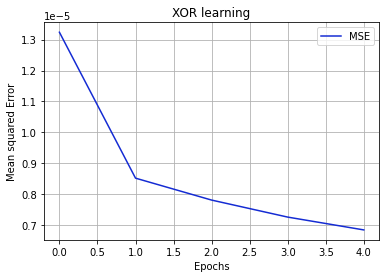

Wall time: 6min 30s


In [69]:
%%time
print("\nTraining Neural Network to recognize Red color layer")
Red_layer_Network = Train_RGB_NetWork(MultiP_Red,XTrain,yTrain,0,epochs = 5)


Training Neural Network to recognize Green color layer



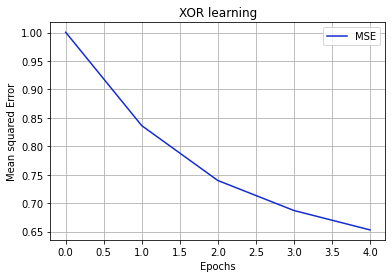

Wall time: 6min 29s


In [18]:
%%time
print("\nTraining Neural Network to recognize Green color layer")
Green_layer_Network = Train_RGB_NetWork(MultiP_Green,XTrain,yTrain,1,epochs = 5)    


Training Neural Network to recognize Blue color layer



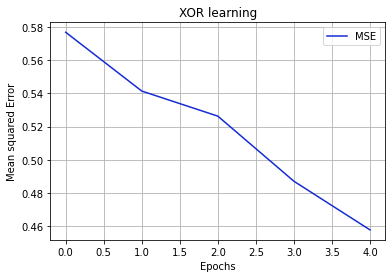

Wall time: 6min 32s


In [19]:
%%time
print("\nTraining Neural Network to recognize Blue color layer")
Blue_layer_Network = Train_RGB_NetWork(MultiP_Blue,XTrain,yTrain,2,epochs = 5)

In [87]:
Save(Red_layer_Network,"Saves/Redlayer_ComputationTime_Network")
Save(Green_layer_Network,"Saves/Greenlayer_ComputationTime_Network")
Save(Blue_layer_Network,"Saves/Bluelayer_ComputationTime_Network")

In [88]:
Red_layer_Network   = Load("Saves/Redlayer_ComputationTime_Network")
Green_layer_Network = Load("Saves/Greenlayer_ComputationTime_Network")
Blue_layer_Network  = Load("Saves/Bluelayer_ComputationTime_Network")

This is the grey images I am goig to use as an input for the test run

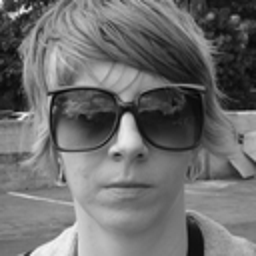

In [63]:
image = PIL.Image.open(XTest[0])
image

In [66]:
%%time

grey_image = GetGrayLayer(XTest[0])


Red_Result = Red_layer_Network.run(grey_image)
Green_Result = Green_layer_Network.run(grey_image)
Blue_Result = Blue_layer_Network.run(grey_image)

Red_Scaled   = [int(element * 255) for element in Red_Result]
Green_Scaled = [int(element * 255)  for element in Green_Result]
Blue_Scaled  = [int(element * 255)  for element in Blue_Result]

r = np.reshape(Red_Scaled,(256,256)) # reshaping it back in to 256 by 256
g = np.reshape(Green_Scaled,(256,256))
b = np.reshape(Blue_Scaled,(256,256))


Wall time: 4.34 s


The output gives an intresting result but there apears to be a weird shape on the womans face.

(-0.5, 255.5, 255.5, -0.5)

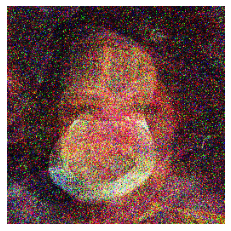

In [65]:
newRGBImage = cv2.merge((r,g,b))  
plt.imshow(newRGBImage)
plt.axis('off')

If we look at the data we trained the network with, we can see that this is the object that we see in the predicted face.

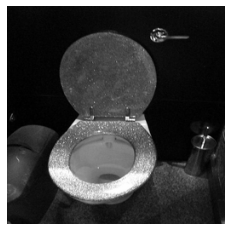

In [67]:
for i in range(len(XTrain)):
    image = PIL.Image.open(XTrain[i])
    plt.imshow(image)
    plt.axis('off')


## Conclusion

Just predicting the color layers gives an intresing out, but it is not the output I am look for. The network learns to create its own picture and we are looking for colorization, So we need to use a diffrent technique. 

---
# Predicting the ab color spectrums - version 1

 This technique transforms RGB to Lab.The L stands for lightness, and a and b for the color scope green to red and blue to yellow. This will make sure the the structure of the image stays the same and only the colors will change!

 ### Example Lab technique 
 Before we create a AI we test out this AI approach.
 
This is the image where going to use

In [52]:
image = PIL.Image.open(XTest[2])
image

This would be the input in to the network

In [88]:
image = PIL.Image.open(yTest[2])
image = np.array(image, dtype=float)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y = Y / 128

X = X.ravel()
Y = Y.ravel()

print("X lenght: ",len(X))
print("Y lenght: ",len(Y) , " = a :",int(len(Y)/2), " b :",int(len(Y)/2))

X lenght:  65536
Y lenght:  131072  = a : 65536  b : 65536


This would be the output of the network and it result in a correct image

(-0.5, 255.5, 255.5, -0.5)

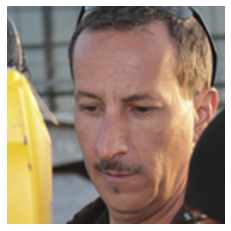

In [71]:
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)
output = Y * 128


cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
image = lab2rgb(cur)
plt.imshow(image)
plt.axis('off') 

And even if there is a wrong color prediction(see example error), the structure of the image stays the same!

(-0.5, 255.5, 255.5, -0.5)

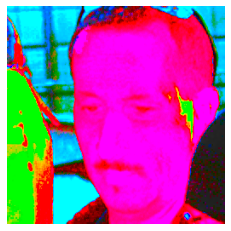

In [90]:
image = PIL.Image.open(yTest[2])
image = np.array(image, dtype=float)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y = Y / 2                          # example of prediction error(2 instead of 128)

X = X.ravel()
Y = Y.ravel()

X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)
output = Y * 128


cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
image = lab2rgb(cur)
plt.imshow(image)
plt.axis('off') 

---
## Trianing the network

Using a small data portion to test out if predicting the color layers, will give the correct result.

In [116]:
yTrain = df_train_color
XTrain = df_train_grey

yTest  = df_test_color
XTest  = df_test_grey

###  Network Model

Creating 3 neural networks for each of the color layers(Red,Green,Blue) in the network. 

The structure of current model is:
- input of 65536 (256 * 256 pixels) 
- 1 hidden layers
 1. 100 perceptrons
- output of 131072 (the predicted A and B color spectrums)

In [6]:
newsize = (64,64)
totalPixels = newsize[0] * newsize[0]

In [212]:
MultiP_Lab   = MultiLayerPerceptron(
    layers=[totalPixels,100,100,100,100,100,(totalPixels *2)]
    ,activations = ["","s","s","s","s","s",""])

In [74]:
%%time
def TrainLAB_NeuralNetwork(network,yTrain,epochs = 25):
    print("\nTraining Neural Network to predict the A B spectrum ")
    data = []
    target_data = yTrain
    
    for i in range(epochs):
        MSE = 0.0
        for j in range(len(target_data)):
            
            image = cv2.imread(target_data[j])
            img_rgb = (image[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)

            (H_orig,W_orig) = img_rgb.shape[:2] # original image size

            img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
            img_l = img_lab[:,:,0] # pull out L channel
            img_c = img_lab[:,:,1:]
            
            img_l_rs  = cv2.resize(img_l, (newsize))
            img_l_rs -= 50
                       
            Y = cv2.resize(img_c, (newsize))
            X = img_l_rs.ravel()
            
            Y = Y /128
            Y = Y.ravel()
            
            MSE += network.Backpropagation(X,Y)
        MSE = MSE/len(target_data)
        data.append(MSE) #adds MSE data to array
    
    print()
    plt.plot(data,label='MSE',color="#142BD3FF")
    plt.xlabel('Epochs') 
    plt.ylabel('Mean squared Error')
    plt.title('XOR learning')
    plt.legend()
    plt.grid()
    plt.show()


Wall time: 0 ns


In [225]:
MultiP_Lab = Load("Saves/MultiP_Lab_ComputationTime_Network_v4")


Training Neural Network to predict the A B spectrum 


<ipython-input-3-0a531ff682f1>:27: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


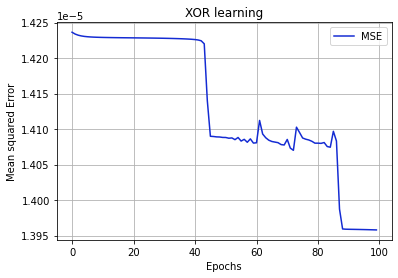

Wall time: 12min 6s


In [257]:
%%time
TrainLAB_NeuralNetwork(MultiP_Lab,yTrain[:5].reset_index(drop=True),epochs = 100)

In [262]:
Save(MultiP_Lab,"Saves/MultiP_Lab_ComputationTime_Network_v4")

Input image

(-0.5, 255.5, 255.5, -0.5)

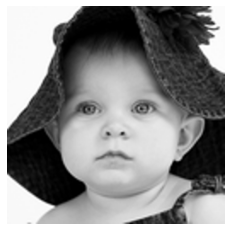

In [157]:
image = PIL.Image.open(XTrain[1])
plt.imshow(image)
plt.axis('off') 

Original image

(-0.5, 255.5, 255.5, -0.5)

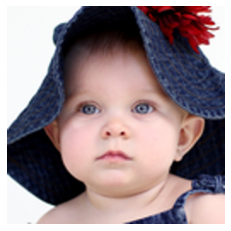

In [220]:
image = PIL.Image.open(yTrain[1])
plt.imshow(image)
plt.axis('off') 

In [17]:
def PredictImage(network,ImagePath):
    image = cv2.imread(ImagePath)
    img_rgb = (image[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
    
    (H_orig,W_orig) = img_rgb.shape[:2] # original image size
    
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l = img_lab[:,:,0] # pull out L channel
    img_l_rs  = cv2.resize(img_l, (newsize))
    img_l_rs -= 50
    
    X = img_l_rs.ravel()
    
    output = network.run(X) 
    
    #output = np.array([math.tanh(element) for element in output])
    
    output = output * 128
    
    # X = X.reshape(1, 64, 64, 1)
    output = output.reshape(64, 64,2)
    
    ab_dec_us = cv2.resize(output, (W_orig, H_orig))
    # print(output)
    img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
    img_bgr_out = lab2rgb(img_lab_out)
    
    image = cv2.resize(img_bgr_out , (H_orig,W_orig))
    return image

Predicted Image 

(-0.5, 255.5, 255.5, -0.5)

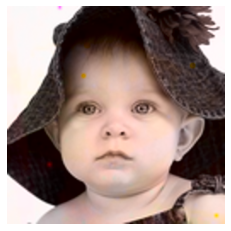

In [261]:
image = PredictImage(yTrain[1])
plt.imshow(image)
plt.axis('off')

## Conclusion

This technique gives a better result than only predicting the RGB colour layers. But there are still some problems that need to be addressed.First, the network mostly predicts tones of brown for the image, this is impressive but it is not the result I was looking for.  Secondly, there appear small pink and yellow dots in the output picture however, this can be fixed by letting the network train more. 

In short, we need to fix these issues if we want a better-looking result, So that is what we will work on in the next version!

---
# Predicting the ab color spectrums  - version 2

Instead of just guessing the layers and see what model works the best by testing, I tried building the model based on the resolution of the image itself. This gives the network in theory more overview over the picture as a whole.

In [9]:
MultiP_Lab_V2 = LoadAI("Saves/MultiP_Lab_V2_ComputationTime_Network_v1")

In [38]:
MultiP_Lab_V2   = MultiLayerPerceptron(
    layers=[totalPixels,64,64,128,128,256,256,512,256,128,64,(totalPixels *2)])

In [39]:
%%time
TrainLAB_NeuralNetwork(MultiP_Lab_V2,yTrain[:100].reset_index(drop=True),epochs = 100)


Training Neural Network to predict the A B spectrum 


<ipython-input-2-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


Wall time: 12min 9s


Original image

In [22]:
image = PIL.Image.open(yTrain[0])
plt.imshow(image)
plt.axis('off') 

(-0.5, 255.5, 255.5, -0.5)

Predicted Image - example 1

<ipython-input-3-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


(-0.5, 255.5, 255.5, -0.5)

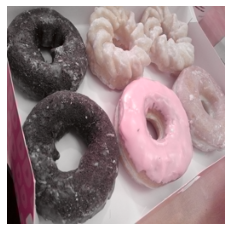

In [12]:
image = PredictImage(MultiP_Lab_V2,yTrain[0])
plt.imshow(image)
plt.axis('off')

Predicted Image - example 2

<ipython-input-3-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


(-0.5, 255.5, 255.5, -0.5)

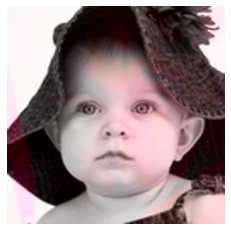

In [16]:
image = PredictImage(MultiP_Lab_V2,yTrain[1])
plt.imshow(image)
plt.axis('off')

In [37]:
Save(MultiP_Lab_V2,"Saves/MultiP_Lab_V2_ComputationTime_Network_v2")

## Conclusion

The model can correclty predict the image from example 1 when there only one training example picture, even the strange pink and yellow orbs has disabpeared! 

But the problem is now that it only works with the trained image(see example 2). So in the next version where going to change the layer structure of the model to see if this helps the overal prediction quality.

---
# Predicting the ab color spectrums - version 3

In  this version where going to change the layer structure to see if there are possible improvemnts to be made. fotr 

In [19]:
MultiP_Lab_V3_encoder = Load("Saves/MultiP_Lab_V2_ComputationTime_Network_v3")

In [29]:
MultiP_Lab_V3_encoder   = MultiLayerPerceptron(
    layers=[totalPixels,64,64,128,128,256,256,512,3,3,512,256,128,64,(totalPixels *2)])


Training Neural Network to predict the A B spectrum 


<ipython-input-3-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


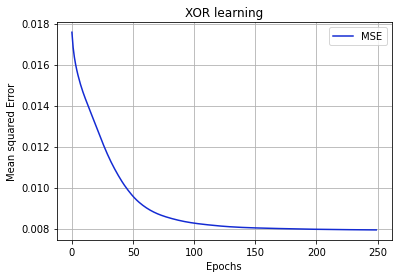

Wall time: 15min 59s


In [25]:
%%time
TrainLAB_NeuralNetwork(MultiP_Lab_V3_encoder,yTrain[20].reset_index(drop=True),epochs = 250)

Original image

(-0.5, 255.5, 255.5, -0.5)

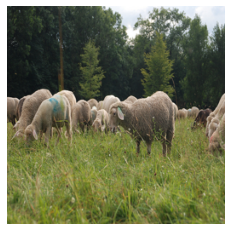

In [41]:
image = PIL.Image.open(yTrain[7])
plt.imshow(image)
plt.axis('off') 

Predicted Image

<ipython-input-3-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))


(-0.5, 255.5, 255.5, -0.5)

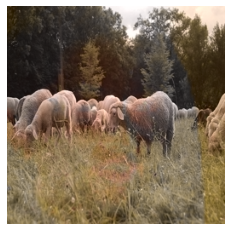

In [26]:
image = PredictImage(MultiP_Lab_V3_encoder,yTrain[7])
plt.imshow(image)
plt.axis('off')

<ipython-input-3-c7f197443036>:28: RuntimeWarning: overflow encountered in exp
  result = 1/(1 + np.exp(-x))
d:\ai_software\python\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 85 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
d:\ai_software\python\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 115 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
d:\ai_software\python\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
d:\ai_software\python\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 362 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
d:\ai_software\python\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return xyz2rgb(lab2xyz(lab

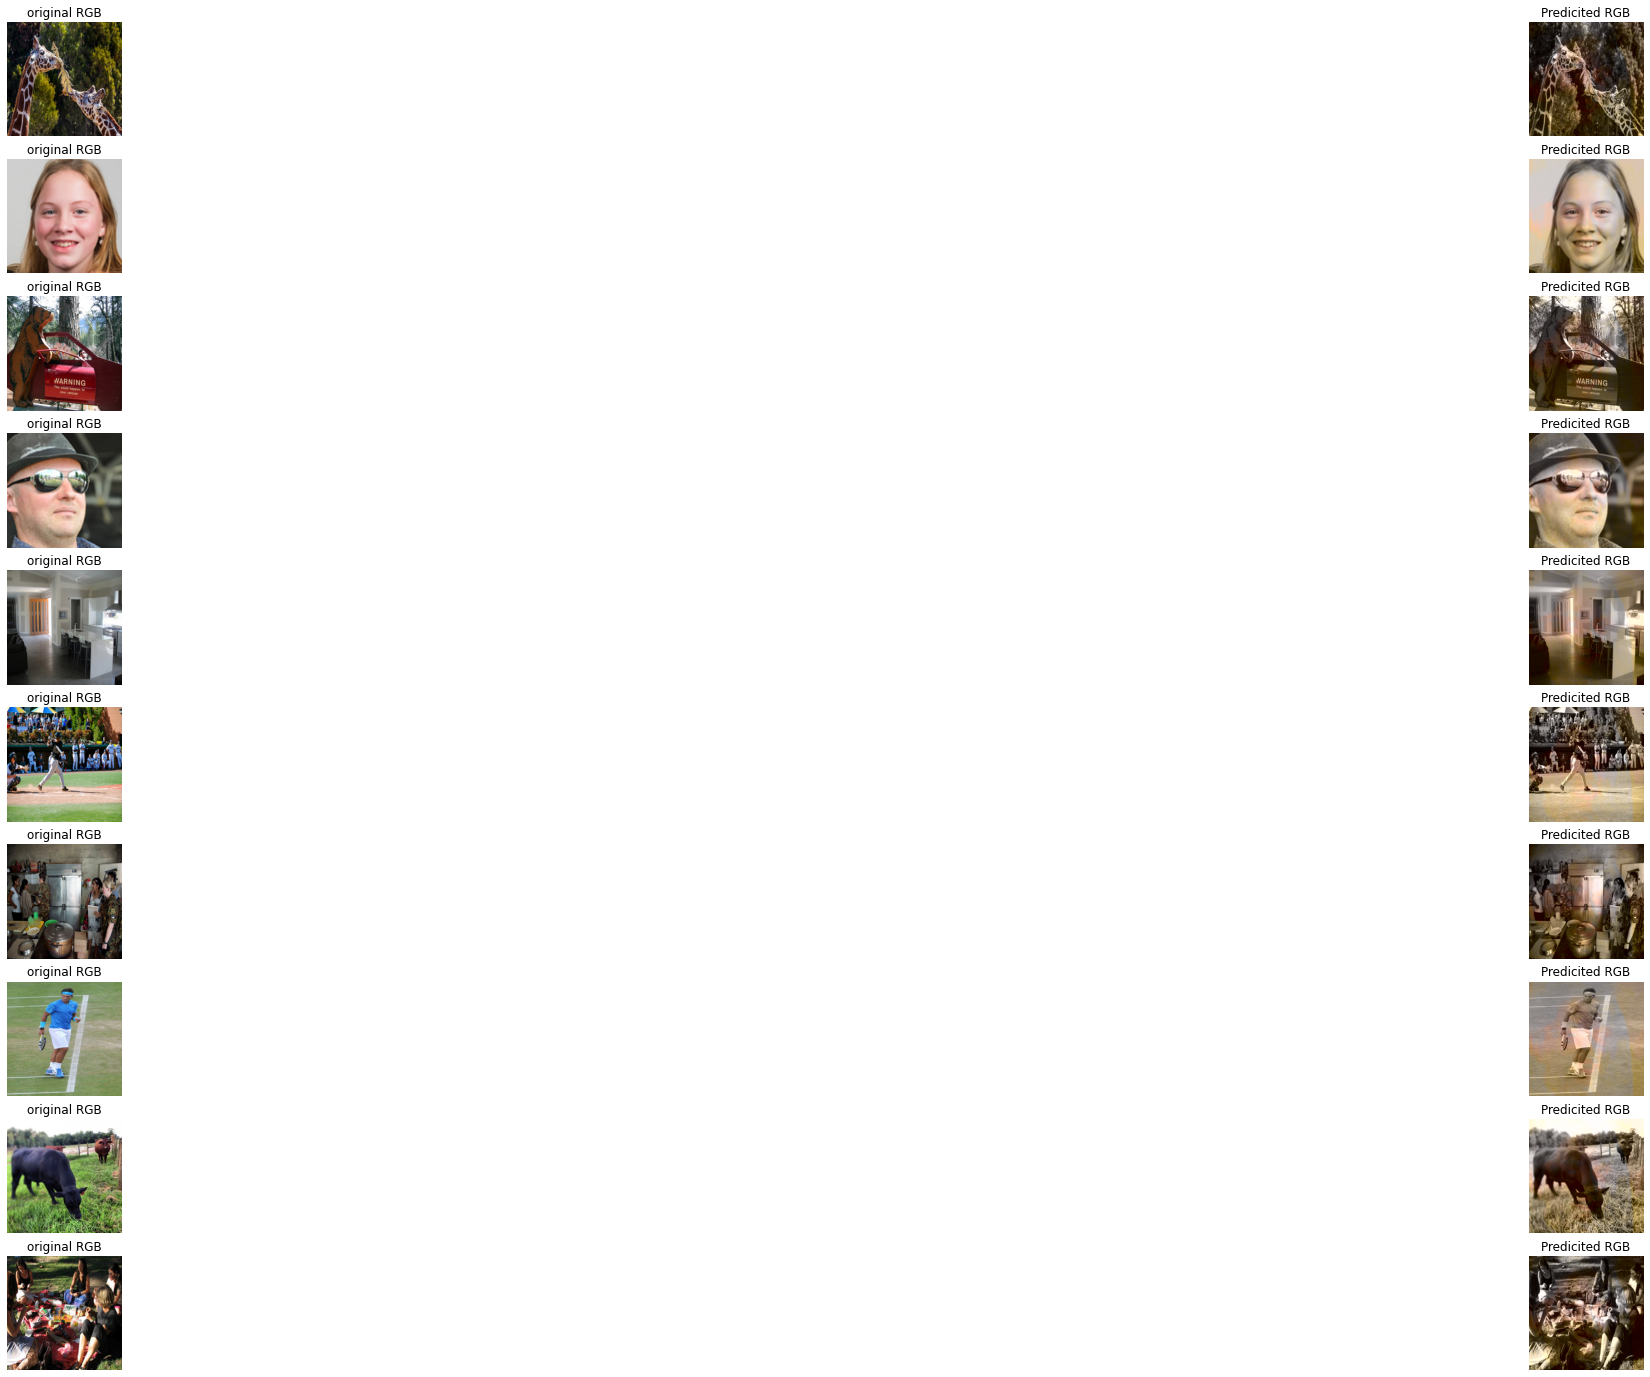

In [27]:
count = 1
Nsample = 20
fig = plt.figure(figsize=(50,50))

for  ImagePath in yTest[10:20].reset_index(drop=True):
    image = PIL.Image.open(ImagePath)
    ax = fig.add_subplot(Nsample,2,count)
    ax.imshow(image); ax.axis("off")
    ax.set_title("original RGB")
    count += 1
    
    ax = fig.add_subplot(Nsample,2,count)
    image2 = PredictImage(MultiP_Lab_V3_encoder,ImagePath)
    ax.imshow(image2); ax.axis("off")
    ax.set_title("Predicited RGB")
    count += 1
    
plt.show()

In [20]:
Save(MultiP_Lab_V3_encoder,"Saves/MultiP_Lab_V2_ComputationTime_Network_v3")

## Conclusion

This is as far as the self-made network is going to get, the problem is that the AI needs a lot more than just firing neurons to be able to work effectively. In each of the versions, the main problem was that the network predict is mages in a brown tint. This is due to how the backpropagation works, the colour brown has apparently the lowest Mean squire error. This means the best possible colour is for this network is brown.

In the next version, I am going to try to work with the neural networks from the **TensorFlow library**.

--- 
# Predicting the ab color spectrums - version 4 (with tensorflow)

In this verion I am going to work with the tensorflow libray, it offesers more possiblies with neural networks than my own created version. For instance it allows to add UpSampling and other need tricks in the network it self, this was not possible with my version of the network.

### loading the tensorflow imports

In [21]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras import Model,Sequential,Input
from tensorflow.keras.models import Sequential
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import backend as K

In [7]:
X = []
for i in range(len(yTrain[:50])):
    X.append(img_to_array(load_img(yTrain[i]))) 
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

# Set up training and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [9]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# #Fusion
# fusion_output = RepeatVector(32 * 32)(embed_input) 
# fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
# fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
# fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))


# Finish model
model.compile(optimizer='rmsprop', loss='mse')

In [31]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)
        

In [21]:
# Train model
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="data/Image Classification in TensorFlow/")
model.fit(image_a_b_gen(batch_size), steps_per_epoch=100, epochs=1)
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 138ms/step - loss: 0.0096
0.009617899544537067


In [22]:
color_me = []
for i in range(len(yTrain[:10])):
        color_me.append(img_to_array(load_img(yTrain[i])))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

sadly our predicting result suffers from the same issues that our own network had. It geralises all of the images to the color brown (a bit beige). 

(-0.5, 255.5, 255.5, -0.5)

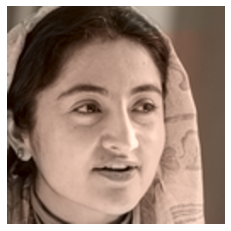

In [43]:
index = 6
cur = np.zeros((256, 256, 3))
cur[:,:,0] = color_me[index][:,:,0]
cur[:,:,1:] = output[index]
image = lab2rgb(cur)
plt.imshow(image)
plt.axis('off')

tensorflow has its own saving system so I dont have to use picle for saving this AI.

In [48]:
model.save("Saves/tensorflow_V1_ComputationTime_Network_v1")

INFO:tensorflow:Assets written to: Saves/tensorflow_V1_ComputationTime_Network_v1\assets


## conclusion 

this version gives us the same result as the self-made neural network, which means that there is a component missing in our network. In the next version, we will combine 2 networks and see if this will improve the overall output. 

---
# Predicting the ab color spectrums - version 5 (with tensorflow and keras)


For this version where going to use the pre-trained model for the libary keras as an encoder.

In [1]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

from keras.applications.vgg16 import VGG16

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### training data

Getting the train data and change the size of the image to the shape of the VGG16 netowrk input.

In [122]:
path = 'data/Training_Set/Color/'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=500, class_mode=None)

inputsize = (224,224)

X =[]
y =[]
for path in train[0]:
    img = path
    img = cv2.resize(img, (inputsize))
    lab = rgb2lab(img)
    X.append(lab[:,:,0]) # grey color layer
    y.append(lab[:,:,1:] / 128) #A-B layer values range from -128 to 128, 

X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(y.shape)

Found 800 images belonging to 1 classes.
(500, 224, 224, 1)
(500, 224, 224, 2)


### VGG16 Model from keras

In this version where using part of the keras Image Recognition model to see paterns in our images, this helps our network beter color in certain part of the picture.

In [2]:
Vgg_Model = VGG16()
Vgg_Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Encoder model

The layers **flatten** , **fc1** ,**fc2** are used as classification and where are only interested in the feature extraction layers. So in order to use it in our own models these layers need to be removed!

In [3]:
encoder_Model = Sequential()

layers = Vgg_Model.layers[:19]

for i in range(len(layers)):
    layers[i].trainable = False # using the pre-trained weights form keras Image Recognition network
    encoder_Model.add(layers[i])
    
encoder_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Saving the encoder

In [4]:
encoder_Model.save('Saves/tensorflow_Encoder_V1_ComputationTime_Network_v4')

INFO:tensorflow:Assets written to: Saves/tensorflow_Encoder_V1_ComputationTime_Network_v4\assets


The encoder_Model is expecting 3 dimension, so we change the gray back to RGB to make it 3 dimations. and fit the output to the shape of the decoder network.  

In [124]:
%%time
features_output = []
for i, Lchannel in enumerate(X):
    Lchannel = gray2rgb(Lchannel)
    Lchannel = Lchannel.reshape((1,224,224,3))
    prediction = encoder_Model.predict(Lchannel)
    prediction = prediction.reshape((7,7,512))
    features_output.append(prediction)
features_output = np.array(features_output)
print(features_output.shape)

(500, 7, 7, 512)
Wall time: 1min 18s


### Decoder model

This part of the model **predicts the colors** for the features that are extracted by the extraction layers from the encoder Model.

In [101]:
decoder_Model = Sequential()

 # input shape of the network(at shape (7,7,512))
decoder_Model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
decoder_Model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
decoder_Model.add(UpSampling2D((2, 2)))
decoder_Model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
decoder_Model.add(UpSampling2D((2, 2)))
decoder_Model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
decoder_Model.add(UpSampling2D((2, 2)))
decoder_Model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
decoder_Model.add(UpSampling2D((2, 2)))
decoder_Model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
decoder_Model.add(UpSampling2D((2, 2)))
decoder_Model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 56, 56, 32)       

### Training the network

In [160]:
%%time
decoder_Model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
decoder_Model.fit(features_output, y, verbose=0, epochs=500, batch_size=128)

Wall time: 38min 2s


Saving the model

In [170]:
decoder_Model.save('Saves/tensorflow_V1_ComputationTime_Network_v4')

INFO:tensorflow:Assets written to: Saves/tensorflow_V1_ComputationTime_Network_v4\assets


Loading the model

In [178]:
decoder_Model = tf.keras.models.load_model('Saves/tensorflow_V1_ComputationTime_Network_v4'
                                           ,custom_objects=None,compile=True)

In [179]:

Predicted_Images = []

for path in yTest[:50]:
    img = load_img(path)
    test = img_to_array(img)
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    
    vggpred = encoder_Model.predict(L)  
    ab      = decoder_Model.predict(vggpred) 

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    Predicted_Image = lab2rgb(cur)
    Predicted_Images.append(Predicted_Image)

### Orignal Images

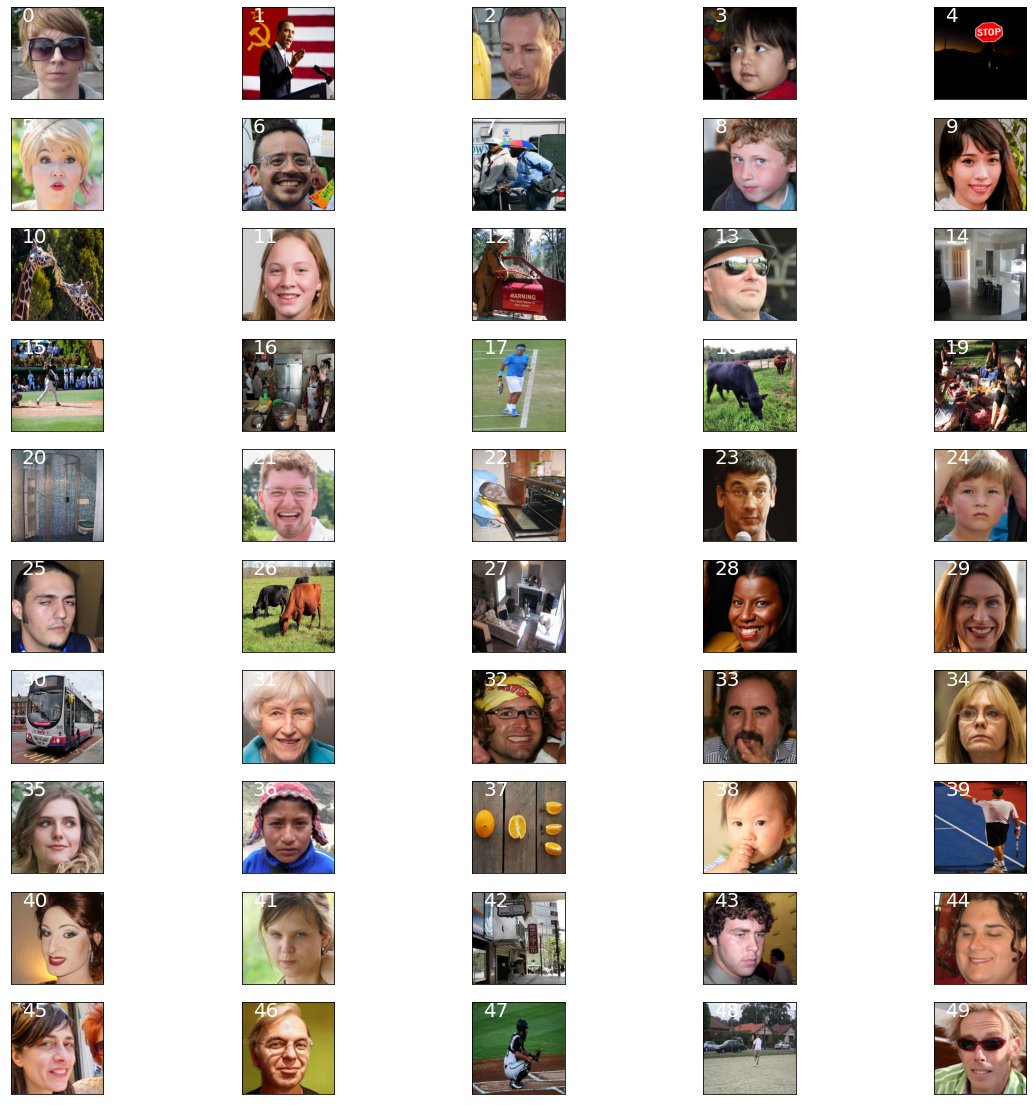

In [174]:
plt.figure(figsize=(20,20))
for i in range(len(yTest[:50])):
    sp = plt.subplot(10,5,i+1)
    sp.text(30,40,i,color = 'white',fontsize = '20')
    single_image = load_img(yTest[i])
    plt.imshow(single_image)
    plt.xticks([])
    plt.yticks([])

### Predicted Images

In [180]:
plt.figure(figsize=(20,20))
for i in range(len(Predicted_Images)):
    sp = plt.subplot(10,5,i+1)
    sp.text(30,40,i,color = 'white',fontsize = '20')
    single_image = Predicted_Images[i]
    
    plt.xticks([])
    plt.yticks([])

## Conclusion 

Using the feature extraction layers from the model **VGG16** and combining the decoder model has proven to be the best network until now. the result looks very detailed and the AI predicts the faces with good accuracy. 

The best-predicted images from this set are at index: 

- (Index 5) the network predicted here blond hair perfectly 
- (Index 15-18-26-47-48) the network predicted the grass correctly
- (Index 6-28) the network was able to predict the colour of certain ethnic groups correctly
- (Index 37) the network predicted even the colour of an orange. 

In short, this version yields the best result until now! In the next version, we're going to use Support Vector Machine SVM in combination with neural networks, to see if it can top this AI. 

---
# (SVM) Support Vector Machine - version 6

In this version the encoder Model will be a **Support Vector Machine**(SVM), The decoder Model will be my own neural network. in the end I will train and validate the results to see wich AI preforms better!

In [234]:
from sklearn import svm,metrics
import keras
from sklearn.model_selection import train_test_split

The will be the categories that the SVM will be able to predict

In [228]:
labels = [
"airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck",
]

In [262]:
from tensorflow.keras.datasets import cifar10

images_data = cifar10.load_data()

(x_train, y_train), (x_test, y_test) = images_data

y_train = y_train.reshape(-1,)


amount_end   = 50000
amount_start = 0

x_train = x_train[amount_start:amount_end]
y_train = y_train[amount_start:amount_end]

x_test = x_test[amount_start:amount_end]
y_test = y_test[amount_start:amount_end]

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [219]:
def ShowImage(x,y):
    img =x    
    
    plt.imshow(img)
    plt.xlabel(labels[y])
    plt.xticks([])
    plt.yticks([])

In [263]:
def flattenData(data):
    lab = rgb2lab(data)
    lab = lab[:,:,0] # grey color layer
    n_samples = len(lab)
    result = lab.reshape((n_samples, -1))
    return result 

X_train = flattenData(x_train)
X_train.shape

(50000, 96)

### Creating the encoder Model


In [92]:
clf = svm.SVC(gamma=0.001,verbose=1,kernel='poly')

In [106]:
%%time
clf.fit(X_train, y_train)

[LibSVM]Wall time: 21.2 s


SVC(gamma=0.001, kernel='poly', verbose=1)

In [259]:
X = flattenData(x_test)
print(X.shape)
predicted = clf.predict(X)

(2000, 96)


In [260]:
print(predicted)

[1 0 8 ... 1 7 5]


#### Testing the predicted result

In [232]:
index = 5
ShowImage(x_train[index],predicted[index])

In [257]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier SVC(gamma=0.001, kernel='poly', verbose=1):
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       155
           1       0.66      0.82      0.74       152
           2       0.68      0.70      0.69       148
           3       0.68      0.69      0.68       140
           4       0.72      0.71      0.72       153
           5       0.80      0.67      0.73       128
           6       0.83      0.72      0.77       159
           7       0.80      0.74      0.77       149
           8       0.74      0.82      0.78       154
           9       0.78      0.66      0.71       162

    accuracy                           0.73      1500
   macro avg       0.74      0.73      0.73      1500
weighted avg       0.74      0.73      0.73      1500




The encoder only needs to send the shape of the object in the image to the right decoder, so accuracy of 73 is acceptable. In the next part were going to create the decoder, this will take the chosen network and predict the right colour.

### Saving the SVM network

In [103]:
Save(clf,"Saves/SVM_poly_Lab_ComputationTime_Network_v1")

In [224]:
encoder = Load("Saves/SVM_poly_Lab_ComputationTime_Network_v1")

### Creating the decoder Model

This AI wil be created with my own neural network, first we need to gader the training data for the decoder model.

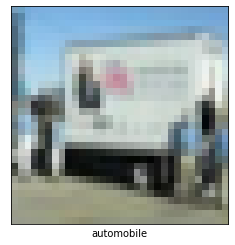

In [267]:
def FilterByLabel(data,label):
    indexes = [i for i in range(len(data)) if data[i] == label]
    return indexes

Labelindexes = []
for i in range(10):
    data = FilterByLabel(y_train,i)
    Labelindexes.append(data)

planes = Labelindexes[9]

ShowImage(x_train[planes[10]],Labelindexes[9][0])

Seting up the Training data

In [209]:
def GetTrainingData(index,amount = 100):
    X = []
    for i in range(amount):
        image = x_train[Labelindexes[index][i]]
        image = img_to_array(image)
        image = cv2.resize(image, (32,32))
        X.append(img_to_array(image))
                 
    X = np.array(X, dtype=float)
    Xtrain = 1.0/255*X
    
    # Set up training and test data
    split = int(0.95*len(X))
    Xtrain = X[:split]
    Xtrain = 1.0/255*Xtrain
    return Xtrain

Designing the structure of the model, and creating a model for each of the labels 

In [108]:
neuralNetworks = []
for i in range(len(labels)):
    model = Sequential()
    model.add(InputLayer(input_shape=(32, 32, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    
    
    # Finish model
    model.compile(optimizer='rmsprop', loss='mse')
    neuralNetworks.append(model)

In [109]:
batch_size = 50
def image_a_b_gen(batch_size,index):
    Xtrain = GetTrainingData(index)   
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

### Training each network

In [210]:
%%time
for i in range(len(neuralNetworks)):
    print("neuralNetwork ",i," is training!")
    neuralNetworks[i].fit(image_a_b_gen(batch_size,i), steps_per_epoch=500, epochs=1)
    # Test images
    Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
    Xtest = Xtest.reshape(Xtest.shape+(1,))
    Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
    Ytest = Ytest / 128
    print(model.evaluate(Xtest, Ytest, batch_size=batch_size))
    print()

neuralNetwork  0  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  1  is training!
1/1 [==============================] - 0s 21ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  2  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  3  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  4  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  5  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  6  is training!
1/1 [==============================] - 0s 28ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  7  is training!
1/1 [==============================] - 0s 20ms/step - loss: 0.0183
0.01829417422413826

neuralNetwork  8  is training!
1/1 [============

### Saving the networks

In [217]:
for i in range(len(neuralNetworks)):
    path ="Saves/SVM_decoder_Lab_ComputationTime_Network_v" + str(i)
    neuralNetworks[i].save(path)

INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v0\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v1\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v2\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v3\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v4\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v5\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v6\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v7\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v8\assets
INFO:tensorflow:Assets written to: Saves/SVM_decoder_Lab_ComputationTime_Network_v9\assets


### Loading the networks

In [215]:
neuralNetworks = []
for i in range(10):
    index = i
    if(i == 6):
        index = 2
    if(i == 4):
        index = 5
    path ="Saves/SVM_decoder_Lab_ComputationTime_Network_v" + str(index)
    model = tf.keras.models.load_model(path,custom_objects=None,compile=True)
    print("SVM_decoder_Lab_ComputationTime_Network_v",i," is loaded!")
    neuralNetworks.append(model)

SVM_decoder_Lab_ComputationTime_Network_v 0  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 1  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 2  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 3  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 4  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 5  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 6  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 7  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 8  is loaded!
SVM_decoder_Lab_ComputationTime_Network_v 9  is loaded!


## looking at the results 

In [179]:
color_me = []
Predicted_indexes = []
amount = 50
for i in range(amount):
    input_image = cv2.imread(XTest[i])
    lab = rgb2lab(input_image)
    lab = lab[:,:,0] # grey color layer
    lab  = cv2.resize(lab, (96,1))
    n_samples = len(lab)
    result = lab.reshape((n_samples, -1))
    Predicted_index = encoder.predict(result)
    
    #decoder
    index = Predicted_index[0]
    Predicted_indexes.append(index)


for i in range(amount):   
    image = load_img(XTest[i])
    image = img_to_array(image)
    color_me.append(image)
    


In [261]:
amount = 50
Predicted_images = []

for i in range(amount):
    
    index = Predicted_indexes[i]
    network = neuralNetworks[index]
    
    color_me_image = color_me[i]
    img_rgb = (color_me_image[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l = img_lab[:,:,0] # pull out L channel
    
    color_me_image = cv2.resize(color_me_image,(32,32))
    color_me_image = [color_me_image]
    
    
    color_me_image = np.array(color_me_image, dtype=float)
    color_me_image = rgb2lab(1.0/255*color_me_image)[:,:,:,0]
    color_me_image = color_me_image.reshape(color_me_image.shape+(1,))
    color_me_image -= 50
    
    Predicted_image = network.predict(color_me_image)
    Predicted_image = Predicted_image * 128
    Predicted_image = Predicted_image.reshape(32, 32,2)
    
    ab_dec_us = cv2.resize(Predicted_image, (256,256))
    img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
    imageColored = lab2rgb(img_lab_out)

    
    Predicted_images.append(imageColored)

plt.figure(figsize=(20,20))
for i in range(amount):
    sp = plt.subplot(10,5,i+1)
    sp.text(30,40,i,color = 'white',fontsize = '20')
    plt.imshow(Predicted_images[i])
    plt.xticks([])
    plt.yticks([])


## conclusion 

The image colourizer with SVM works better than the neural network versions 1 to 4. The AI can colour in some of the faces(see images at index **5-21-44-49** above) which is very interesting! but the overall quality is worse than neural network version 5. I think with more categories the network would be able to improve even more, but the downside of this design is that it is not scalable. When there is something the AI does not recognize in the input, the structure of the network needs to be changed instead of just retrained.  

And that is the reason why I will stop with this design, and use  **neural network version 5** as best AI instead!

---
# Final Conclusion 

In this document, I created lots of different versions and tested their result to see what network design worked best. I soon found out that predicting the **RGB Layers** (version 0) was not the correct approach for this project, it predicted the new image and did not take the structure from the input into account. 

So I tried the LAB technique(see version 1 for more information), this proved to work better, it kept the overall structure of the picture but when the network was trained for a long period the **colours averaged down** to the **colour brown/beige**. Only if I trained one type of image(for example an forest picture) this would not occur, but it meant that the odder predictions would not be looking natural and having the same colors as the training image.

This colour problem would be present from versions 1 to 4,so in **version 5** it tried using 2 neural networks. One for feature extraction (encoder) and the other one for colouring in those features (decoder), this would later prove to be the best one. In **version 6** I added the **Support Vector Machine (SVM)** as an encoder to see if it would produce equal or even better results. The predicted images were looking better than the result from version 1 to 4, but the overall quality was worse than version 5. So because of the shortage of time left and the computation time it takes to train these AI, I chose the **neural network version 5** as the best performing AI, and it will be used in the next project phase the **Delivery**.

This is the end of this Predictions document, in the next document **"Colourizing Black and White Images Delivery"** I will use this network to create a user-friendly app. 